In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from file_lists import get_file_list
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
%matplotlib inline
%run data_prep_functions.ipynb

### <font color='royalblue'> Read the data (test runs below 15 seconds)

In [92]:
file_path = "E:\POSITION DATA\PRE PROCESSED/below15_runs.csv"
below15 = pd.read_csv(file_path)

In [93]:
below15.head()

,session,rat,run_nr,start_timestamp,run_type,stim_condition,outcome,group,cp_entry_timestamp,cp_exit_timestamp,latency_to_cp_entry,latency_to_cp_exit,time_in_cp
0,2019-08-08T12_41_07,NPHR1,6.0,368.579635,T,1,1.0,NPHR,371.569088,372.640947,2.989453,4.061312,1.071859
1,2019-08-08T12_41_07,NPHR1,10.0,751.518003,T,3,1.0,NPHR,755.435469,756.431386,3.917466,4.913382,0.995917
2,2019-08-08T12_41_07,NPHR1,14.0,954.084992,T,3,0.0,NPHR,957.866982,958.900954,3.781990,4.815962,1.033971
3,2019-08-08T12_41_07,NPHR1,18.0,1151.446016,T,0,1.0,NPHR,1153.832614,1154.563149,2.386598,3.117133,0.730534
4,2019-08-08T12_41_07,NPHR1,22.0,1375.846490,T,3,1.0,NPHR,1378.606669,1379.300582,2.760179,3.454093,0.693914


### <font color='royalblue'>Remove pre-illuminated and sample illuminated trials

In [94]:
below15 = below15[(below15['stim_condition']==0)|(below15['stim_condition']==3)]
below15['stim_condition'].unique()

array([3, 0], dtype=int64)

In [95]:
counts=below15.groupby(['group','stim_condition']).count()['session']
counts

group  stim_condition
CTRL   0                  954
       3                  937
NPHR   0                 1196
       3                 1164
Name: session, dtype: int64

## <font color='royalblue'> Latency to choice point across sessions

In [96]:
# Add session numbers to each session timestamp
def add_session_nr(group):
    
    session_list = np.sort(group['session'].unique())
    i=1  
    for session in session_list:
        group.loc[group['session']==session,'session_nr']=i
        i+=1
    return group

below15= below15.groupby(['group', 'rat']).apply(add_session_nr).reset_index(drop=True)

In [97]:
# Calculate the median latencies across sessions
medians = below15.groupby(['group','stim_condition','rat','session_nr'])['latency_to_cp_entry'].apply(np.median)
medians = medians.reset_index()

#Remove two extra sessions from NPHR6
medians = medians[medians['session_nr'].between(0,15)]

### Median latency across sessions within each group

<Figure size 1800x1200 with 0 Axes>

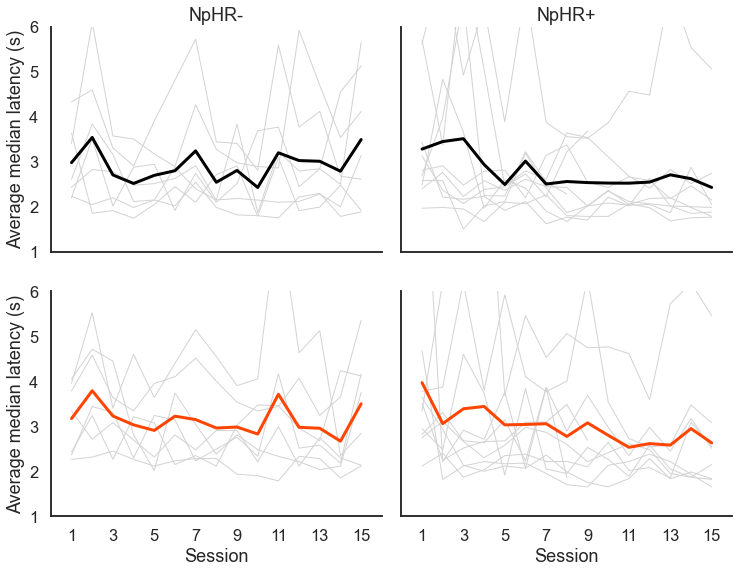

In [98]:
plt.figure(dpi=300)
sns.set(style='white', context='talk')
g = sns.relplot(kind='line', data=medians, col='group', row='stim_condition',
                x='session_nr', y='latency_to_cp_entry', hue='rat',
                height=4, aspect=1.3, linewidth=1,palette=['lightgray']*17)

for group, ax in g.axes_dict.items():
    if 0 in group:
        color='black'
    else:
        color='orangered'
        
    data = medians[(medians['group']==group[1]) & (medians['stim_condition']==group[0])]
    sns.lineplot(data=data, x='session_nr', y='latency_to_cp_entry',
                 ci=None, color=color, linewidth=3, ax=ax, legend=False)
    
g.set(ylabel= 'Average median latency (s)', xlabel='Session', xlim=[0,16], ylim=[1,6],
      xticks=range(1,16,2), xticklabels=range(1,16,2))
g._legend.remove()
axes = g.axes.flatten()
axes[0].set(title="NpHR-")
axes[1].set(title="NpHR+")
axes[2].set(title="")
axes[3].set(title="")
sns.despine()

### Latency to choice point entry distributions (boxplots) across sessions

In [163]:
below15=below15[below15['session_nr'].between(1,15)]

<Figure size 6000x3000 with 0 Axes>

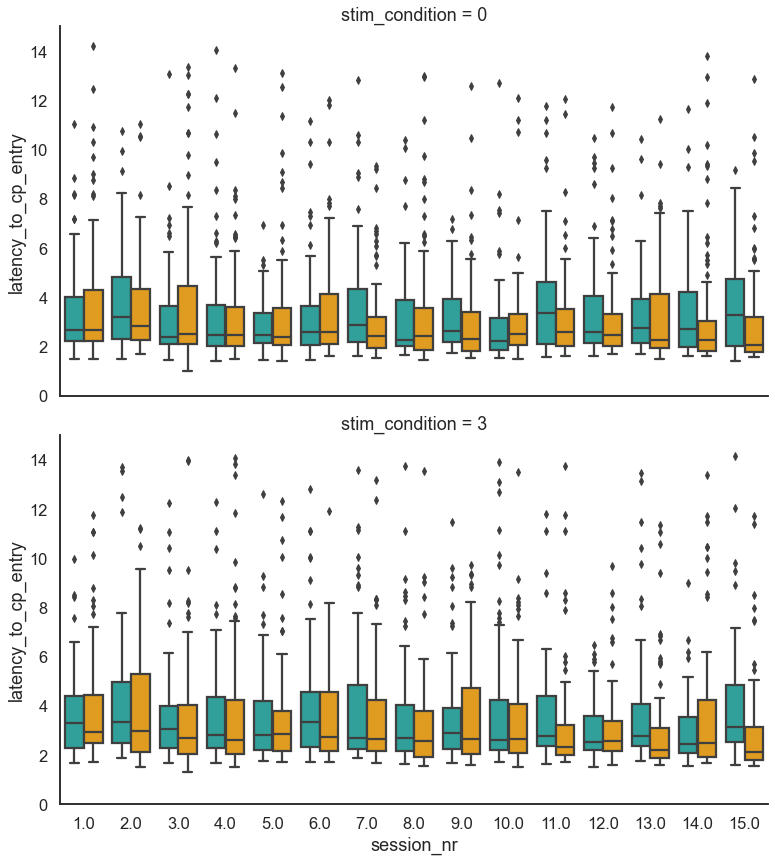

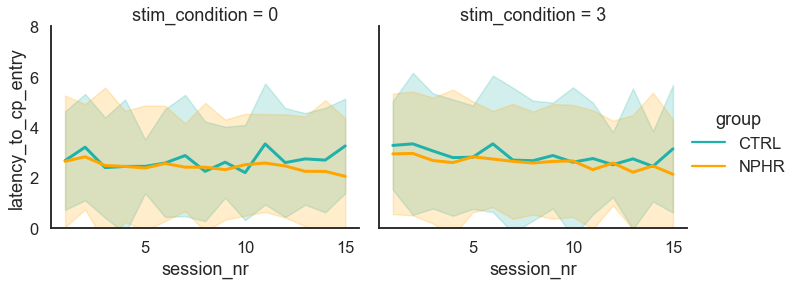

In [195]:
plt.figure(figsize=(20,10),dpi=300)
sns.set(style='white', context='talk')
g = sns.catplot(kind='box',data=below15, row='stim_condition',
                x='session_nr', y='latency_to_cp_entry', hue='group', hue_order=['CTRL','NPHR'],
                height=6, aspect=1.8, legend=False, palette=['lightseagreen', 'orange']
                )
   
a = sns.relplot(kind='line',data=below15, col='stim_condition', x='session_nr', y='latency_to_cp_entry', 
             hue='group', hue_order=['CTRL','NPHR'], estimator=np.median, linewidth=3, ci='sd',
                palette=['lightseagreen','orange'], height=4, aspect=1.2 )

g.set(ylim=[0,15])
a.set(ylim=[0,8])
sns.despine()

### Median latency difference across sessions in each group

In [99]:
medians_illumination = medians[medians['stim_condition']==3].reset_index(drop=True).sort_index()
medians_no_illumination = medians[medians['stim_condition']==0].reset_index(drop=True).sort_index()
medians_illumination['median_diff'] = medians_no_illumination['latency_to_cp_entry'] - medians_illumination['latency_to_cp_entry']
medians_diff = medians_illumination.drop(['latency_to_cp_entry'], axis=1)
medians_diff.head()

,group,stim_condition,rat,session_nr,median_diff
0,CTRL,3,CTRL2,1.0,0.294874
1,CTRL,3,CTRL2,2.0,-0.857818
2,CTRL,3,CTRL2,3.0,-1.167622
3,CTRL,3,CTRL2,4.0,-0.945792
4,CTRL,3,CTRL2,5.0,-0.267635


<Figure size 1800x1200 with 0 Axes>

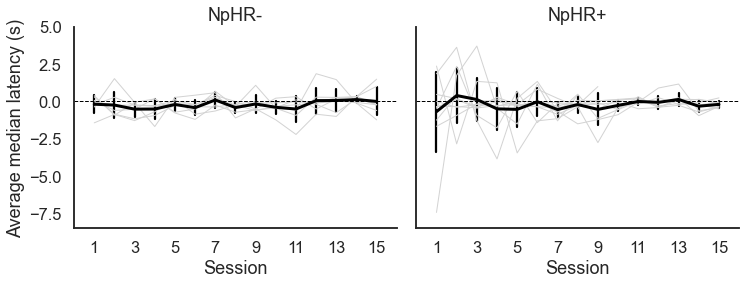

In [100]:
plt.figure(dpi=300)
sns.set(style="white", context='talk')

g = sns.relplot(kind='line', data=medians_diff, col='group', row='stim_condition',
                x='session_nr', y='median_diff', hue='rat', legend=False,
                height=4, aspect=1.3, linewidth=1, palette=['lightgray']*17)

for group, ax in g.axes_dict.items():
 
    data = medians_diff[medians_diff['group']==group[1]]
    sns.lineplot(data=data, x='session_nr', y='median_diff',
                 ci='sd', color='black', linewidth=3, ax=ax, err_style='bars',
                 legend=False)

g.set(ylabel= 'Average median latency (s)', xlabel='Session', xlim=[0,16], ylim=[-8.5,5],
      xticks=range(1,16,2), xticklabels=range(1,16,2))
  
ax=g.axes.flatten()
ax[0].axhline(linewidth=1, color='black', linestyle='dashed')
ax[1].axhline(linewidth=1, color='black', linestyle='dashed')
ax[0].set(title='NpHR-')
ax[1].set(title='NpHR+')
sns.despine()

### Comparing first and last n session distributions in each condition - illumination

In [101]:
def get_first_and_last_n_sessions(df, n):
   
    df.loc[:, 'first_last']=np.nan
    df.loc[df['session_nr'].between(1,n), 'first_last']=0
    df.loc[df['session_nr'].between(16-n, 15), 'first_last']=1
   
    return df

In [102]:
below15 = get_first_and_last_n_sessions(below15, 5)

In [127]:
illumination = below15[below15['stim_condition']==3]
no_illumination = below15[below15['stim_condition']==0]
ctrl_illumination = illumination[illumination['group']=='CTRL']
nphr_illumination = illumination[illumination['group']=='NPHR']
ctrl_no_illumination =no_illumination[no_illumination['group']=='CTRL']
nphr_no_illumination =no_illumination[no_illumination['group']=='NPHR']

In [104]:
illumination_medians = illumination.groupby(['group','first_last', 'rat', 'session'])['latency_to_cp_entry'].apply(np.median).reset_index()
illumination_medians.groupby(['group', 'first_last']).count()

rat  session  latency_to_cp_entry
group first_last                                   
CTRL  0.0          35       35                   35
      1.0          35       35                   35
NPHR  0.0          50       50                   50
      1.0          40       40                   40

<Figure size 1800x1200 with 0 Axes>

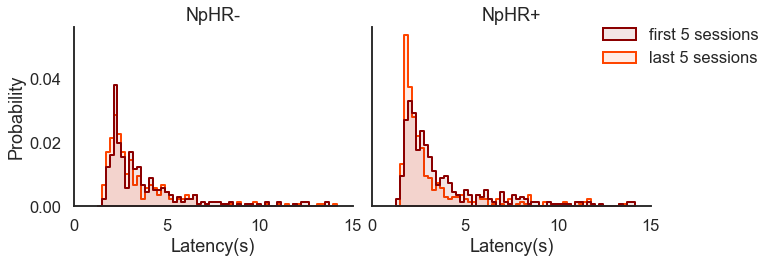

In [116]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)

g = sns.displot(kind='hist', data=illumination, col='group', x='latency_to_cp_entry',
            stat='probability', hue=illumination['first_last'].map({0:'first 5 sessions ', 1:'last 5 sessions '}), 
            col_order=['CTRL', 'NPHR'], element='step', palette=['darkred','orangered'], 
            bins=60, alpha=.1, height=4, aspect=1.2, linewidth=2)

axes = g.axes.flatten()
axes[0].set(title="NpHR-", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].set(title="NpHR+", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
g._legend.set(bbox_to_anchor=(.9,.75), title='')
sns.despine()

<Figure size 1800x1200 with 0 Axes>

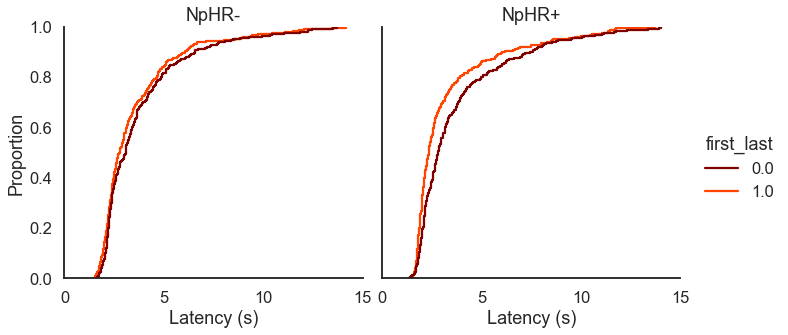

In [80]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)
g = sns.displot(kind='ecdf', data=illumination, col='group' , x='latency_to_cp_entry',
            stat='proportion', hue='first_last', col_order=['CTRL', 'NPHR'], palette=['maroon','orangered'])

axes = g.axes.flatten()
axes[0].set(title="NpHR-", xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].set(title="NpHR+", xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
sns.despine()

In [140]:
#Calculate the percentiles
ctrl_first_illum = ctrl_illumination[ctrl_illumination['first_last']==0]
ctrl_last_illum = ctrl_illumination[ctrl_illumination['first_last']==1]
nphr_first_illum = nphr_illumination[nphr_illumination['first_last']==0]
nphr_last_illum = nphr_illumination[nphr_illumination['first_last']==1]

ctrl_first_illum_percentiles = np.percentile(ctrl_first_illum['latency_to_cp_entry'], range(0,101,1))
ctrl_last_illum_percentiles = np.percentile(ctrl_last_illum['latency_to_cp_entry'], range(0,101,1))

nphr_first_illum_percentiles = np.percentile(nphr_first_illum['latency_to_cp_entry'], range(0,101,1))
nphr_last_illum_percentiles = np.percentile(nphr_last_illum['latency_to_cp_entry'], range(0,101,1))

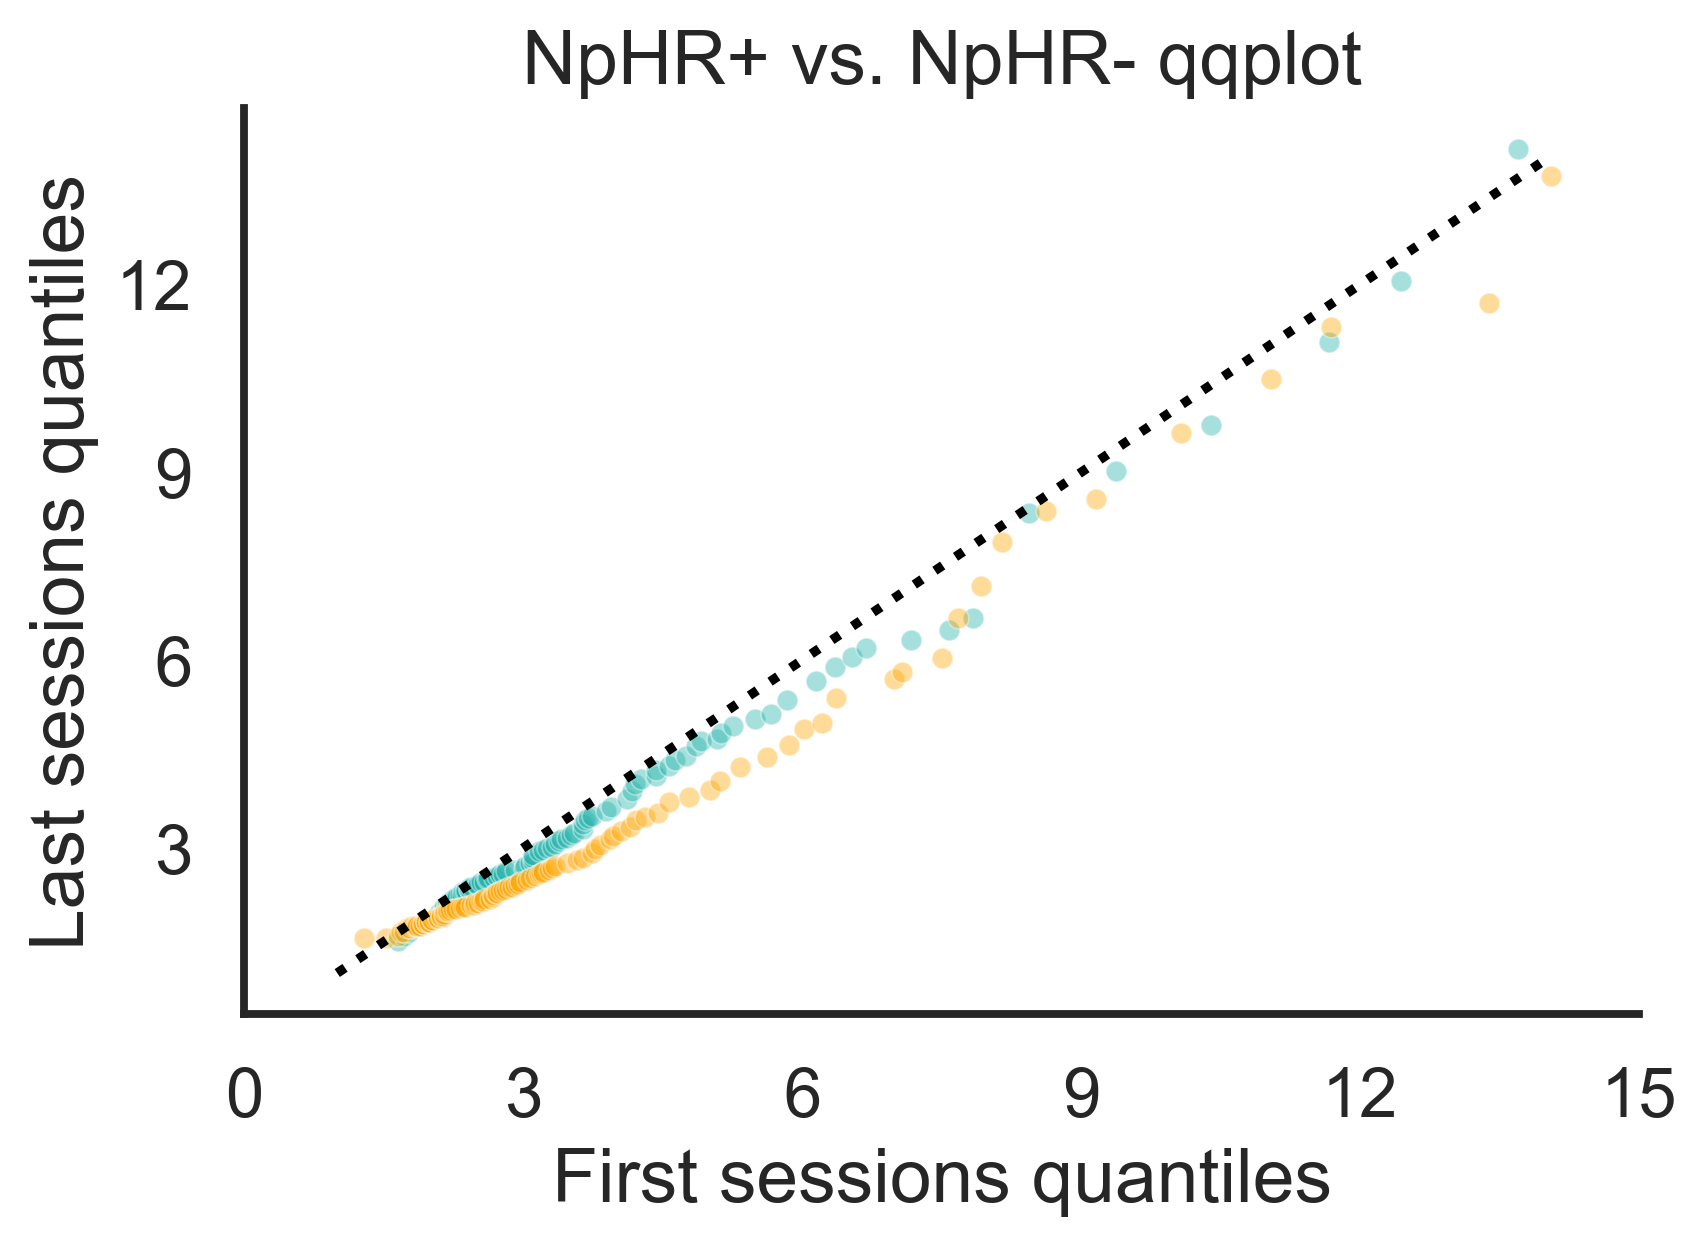

In [145]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)
g = sns.scatterplot(x=ctrl_first_illum_percentiles, y=ctrl_last_illum_percentiles, s=25, alpha=.4, color='lightseagreen')
sns.scatterplot(x=nphr_first_illum_percentiles, y=nphr_last_illum_percentiles, s=25, alpha=.4, color='orange')

g.set(title='NpHR+ vs. NpHR- qqplot', xlabel='First sessions quantiles', ylabel='Last sessions quantiles', xlim=[0,15],
      xticks=range(0,16,3), xticklabels=range(0,16,3), yticks=range(0,16,3), yticklabels=range(0,16,3))
plt.plot(range(1,15,1), range(1,15,1), linestyle='dotted', c='black')

sns.despine()

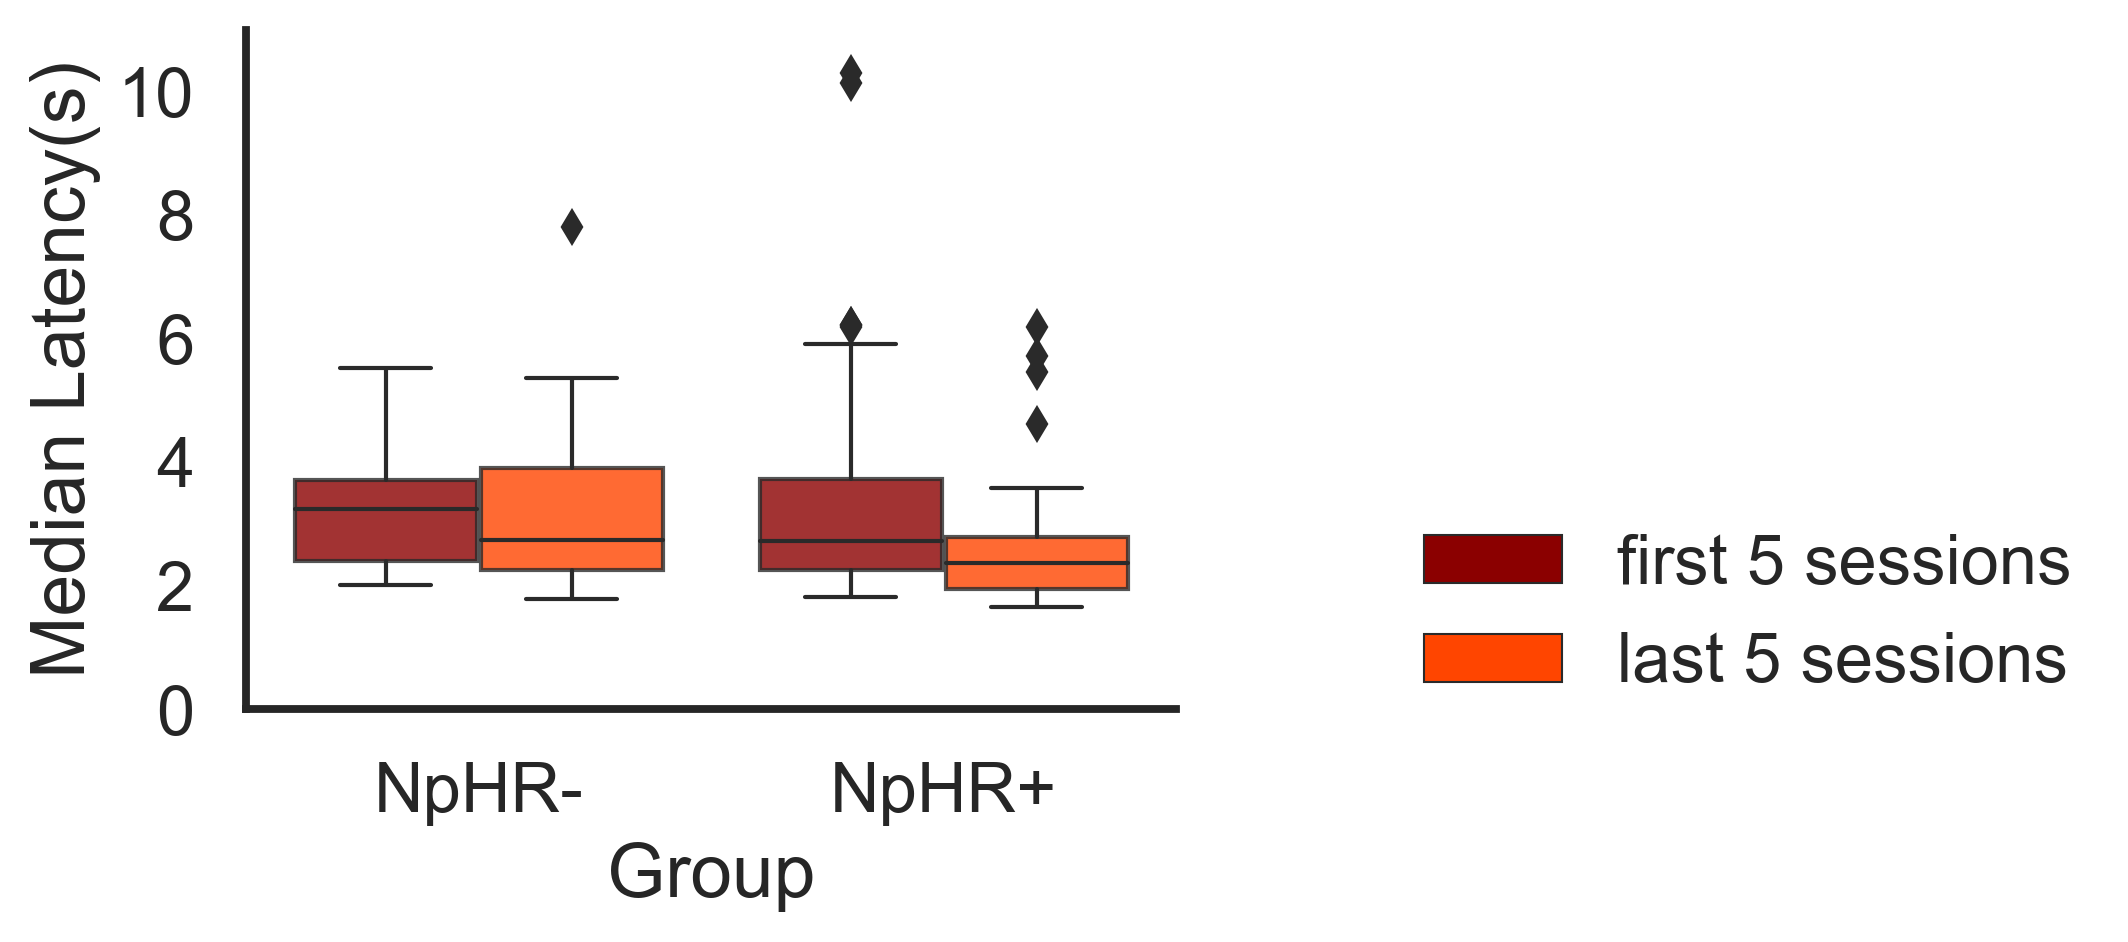

In [114]:
sns.set(style='white', context='talk')
plt.figure(figsize=(4,3), dpi=300)
g = sns.boxplot(
                data=illumination_medians, x='group', y='latency_to_cp_entry', 
                hue=illumination_medians['first_last'].map({0:'first 5 sessions', 1:'last 5 sessions'}),
                palette=['darkred','orangered'], linewidth=1, dodge=True,
                boxprops=dict(alpha=.8), saturation=1)

g.set(xlabel='Group', ylabel='Median Latency(s)', xticks=[0,1], 
      xticklabels=['NpHR-', 'NpHR+'], ylim=[0,11], yticks=range(0,11,2), yticklabels=range(0,11,2))
plt.legend(bbox_to_anchor=(1.2,.35), title='', frameon=False)
sns.despine()

In [130]:
ctrl_illum_first = ctrl_illumination[ctrl_illumination['first_last']==0]
ctrl_illum_last = ctrl_illumination[ctrl_illumination['first_last']==1]
u, p = mannwhitneyu(x=ctrl_illum_first['latency_to_cp_entry'], y=ctrl_illum_last['latency_to_cp_entry'])
print('NpHR-, Illumination, first vs. last: '+str(u)+', '+str(p))

NpHR-, Illumination, first vs. last: 43009.0, 0.031324405229019685


In [131]:
nphr_illum_first = nphr_illumination[nphr_illumination['first_last']==0]
nphr_illum_last = nphr_illumination[nphr_illumination['first_last']==1]
u, p = mannwhitneyu(x=nphr_illum_first['latency_to_cp_entry'], y=nphr_illum_last['latency_to_cp_entry'])
print('NpHR+, Illumination, first vs. last: '+str(u)+', '+str(p))

NpHR+, Illumination, first vs. last: 56157.0, 7.033372054322787e-07


### Comparing first and last n session distributions in each condition - no illumination

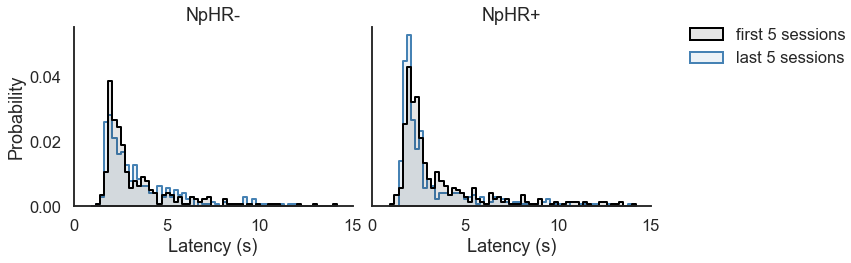

In [75]:
no_illumination = below15[below15['stim_condition']==0]

sns.set(style='white', context='talk')

g = sns.displot(kind='hist', data=no_illumination, col='group', x='latency_to_cp_entry',
                hue=no_illumination['first_last'].map({0:'first 5 sessions ', 1:'last 5 sessions '}), 
                stat='probability', col_order=['CTRL', 'NPHR'], element='step', 
                palette=['black','steelblue'], bins=60, alpha=.1, height=4, aspect=1.2, linewidth=2)

axes = g.axes.flatten()
axes[0].set(title="NpHR-", xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].set(title="NpHR+",xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
g._legend.set(bbox_to_anchor=(1,.75), title='')
sns.despine()

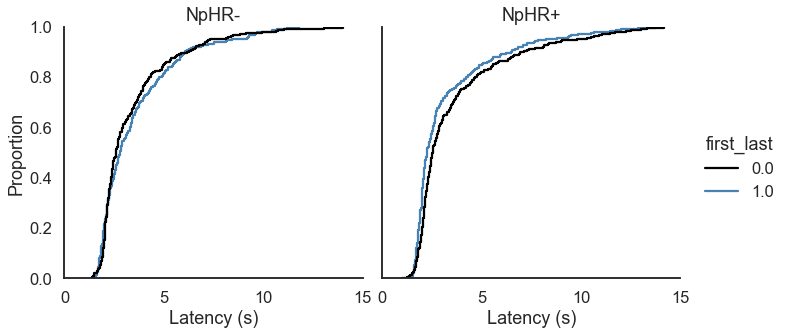

In [133]:
g = sns.displot(kind='ecdf', data=no_illumination, col='group' , x='latency_to_cp_entry',
            stat='proportion', hue='first_last', col_order=['CTRL', 'NPHR'], palette=['black','steelblue'])

axes = g.axes.flatten()
axes[0].set(title="NpHR-", xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].set(title="NpHR+", xlabel='Latency (s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
sns.despine()

In [151]:
ctrl_no_illum_first = ctrl_no_illumination[ctrl_no_illumination['first_last']==0]
ctrl_no_illum_last = ctrl_no_illumination[ctrl_no_illumination['first_last']==1]
u, p = mannwhitneyu(x=ctrl_no_illum_first['latency_to_cp_entry'], y=ctrl_no_illum_last['latency_to_cp_entry'])
print('NpHR-, No Illumination, first vs. last: '+str(u)+', '+str(p))

NpHR-, No Illumination, first vs. last: 48870.0, 0.23501452478381785


In [153]:
nphr_no_illum_first = nphr_no_illumination[nphr_no_illumination['first_last']==0]
nphr_no_illum_last = nphr_no_illumination[nphr_no_illumination['first_last']==1]
u, p = mannwhitneyu(x=nphr_no_illum_first['latency_to_cp_entry'], y=nphr_no_illum_last['latency_to_cp_entry'])
print('NpHR+, No Illumination, first vs. last: '+str(u)+', '+str(p))

NpHR+, No Illumination, first vs. last: 65630.0, 6.442434239782954e-05


In [146]:
#Calculate the percentiles
ctrl_first_no_illum = ctrl_no_illumination[ctrl_no_illumination['first_last']==0]
ctrl_last_no_illum = ctrl_no_illumination[ctrl_no_illumination['first_last']==1]
nphr_first_no_illum = nphr_no_illumination[nphr_no_illumination['first_last']==0]
nphr_last_no_illum = nphr_no_illumination[nphr_no_illumination['first_last']==1]

ctrl_first_no_illum_percentiles = np.percentile(ctrl_first_no_illum['latency_to_cp_entry'], range(0,101,1))
ctrl_last_no_illum_percentiles = np.percentile(ctrl_last_no_illum['latency_to_cp_entry'], range(0,101,1))

nphr_first_no_illum_percentiles = np.percentile(nphr_first_no_illum['latency_to_cp_entry'], range(0,101,1))
nphr_last_no_illum_percentiles = np.percentile(nphr_last_no_illum['latency_to_cp_entry'], range(0,101,1))

In [76]:
no_illumination_medians = illumination.groupby(['group','first_last', 'rat', 'session'])['latency_to_cp_entry'].apply(np.median).reset_index()
no_illumination_medians.groupby(['group', 'first_last']).count()

rat  session  latency_to_cp_entry
group first_last                                   
CTRL  0.0          35       35                   35
      1.0          35       35                   35
NPHR  0.0          50       50                   50
      1.0          40       40                   40

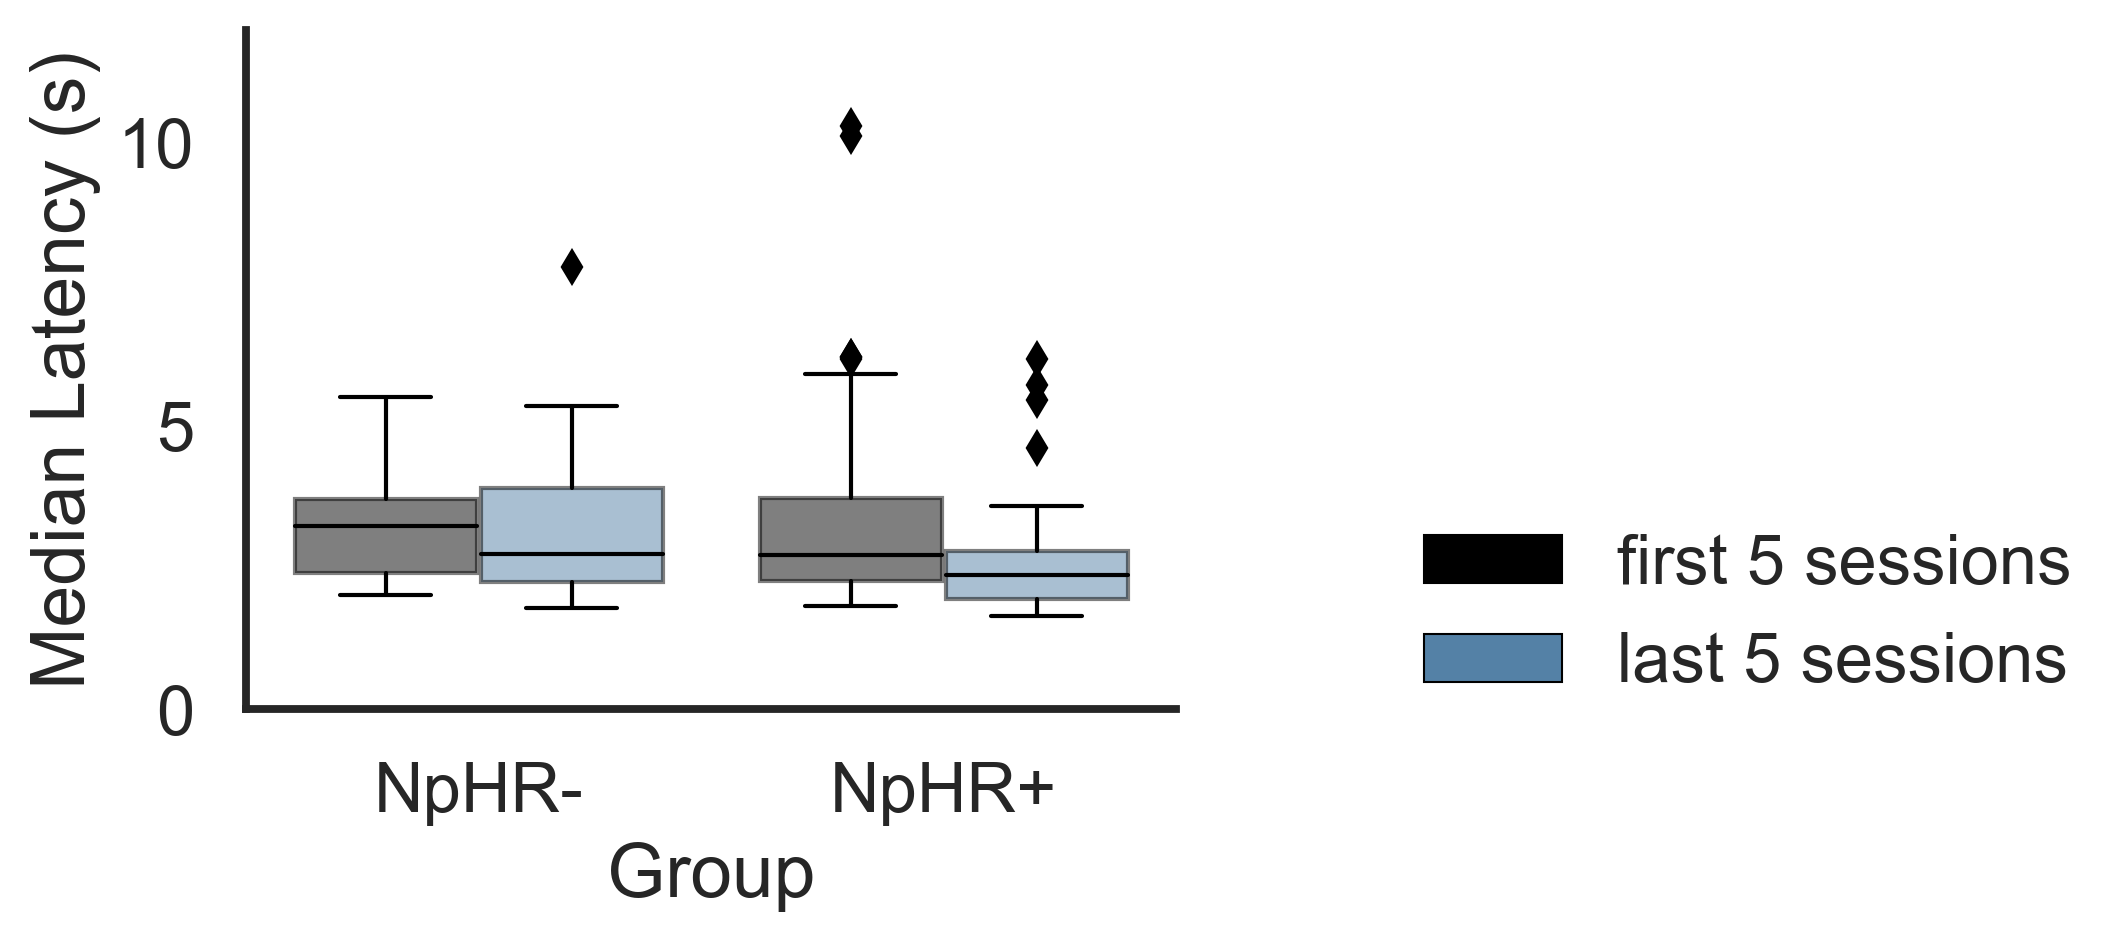

In [79]:
sns.set(style='white', context='talk')
plt.figure(figsize=(4,3),dpi=300)

g = sns.boxplot(
                data=no_illumination_medians, x='group', y='latency_to_cp_entry', 
                hue=no_illumination_medians['first_last'].map({0:'first 5 sessions', 1:'last 5 sessions'}),
                palette=['black','steelblue'], linewidth=1, dodge=True,
                boxprops=dict(alpha=.5))

g.set(xlabel='Group', ylabel='Median Latency (s)', xticks=[0,1], xticklabels=['NpHR-', 'NpHR+'],
      ylim=[0,12])
plt.legend(bbox_to_anchor=(1.2,.35), title='', frameon=False)
sns.despine()
sns.despine()

### Median latency difference across sessions in each group

<Figure size 1800x1200 with 0 Axes>

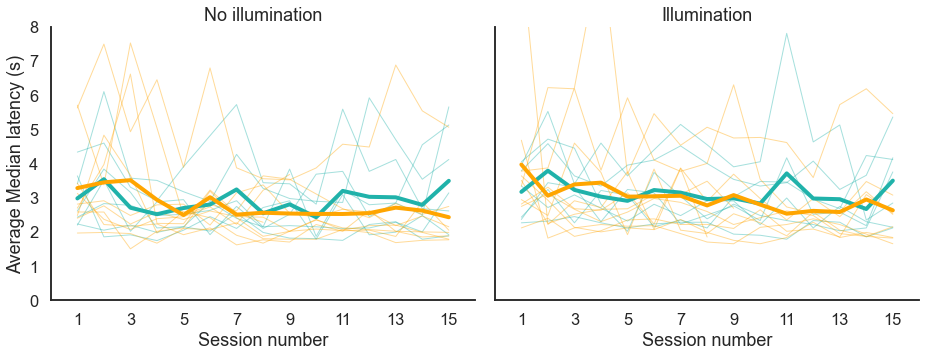

In [154]:
plt.figure(dpi=300)
sns.set(style='white', context='talk')
g = sns.relplot(kind='line', data=medians, col='stim_condition', x='session_nr', 
                y='latency_to_cp_entry', hue='rat', col_order=[0,3], linewidth=1, 
                height=5, aspect=1.3, palette=['lightseagreen']*7+['orange']*10, alpha=.4)

for group, ax in g.axes_dict.items():
    data = medians[medians['stim_condition']==group]
    sns.lineplot(data=data, x='session_nr', y='latency_to_cp_entry', hue='group',
                 ci=None, palette=['lightseagreen','orange'], linewidth=4, ax=ax, legend=False)
     
g.set(ylabel= 'Average Median latency (s)', xlabel='Session number', xlim=[0,16],
      xticks=range(1,16,2), xticklabels=range(1,16,2), ylim=[0,8])
g._legend.remove()
axes = g.axes.flatten()
axes[0].set(title="No illumination")
axes[1].set(title="Illumination")
sns.despine()

<Figure size 1800x1200 with 0 Axes>

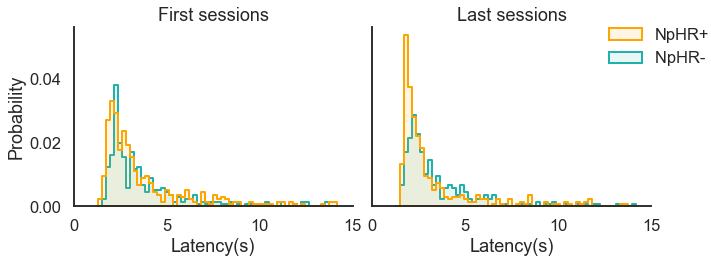

In [120]:
sns.set(style='white', context='talk')
plt.figure(dpi=300)

g = sns.displot(kind='hist', data=below15, col='first_last', x='latency_to_cp_entry',
            stat='probability', hue=illumination['group'].map({'CTRL':'NpHR- ', 'NPHR':'NpHR+'}), 
            col_order=[0, 1], element='step', palette=['orange','lightseagreen'], 
            bins=60, alpha=.1, height=4, aspect=1.2, linewidth=2)

axes = g.axes.flatten()
axes[0].set(title="First sessions", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
axes[1].set(title="Last sessions", xlabel='Latency(s)', xticks=range(0,20,5), xticklabels=range(0,20,5))
g._legend.set(bbox_to_anchor=(.9,.75), title='')
sns.despine()

## Latency across sessions subdivided by outcome

In [157]:
# Calculate the median latencies across sessions
medians = below15.groupby(['group','stim_condition','outcome','rat','session_nr'])['latency_to_cp_entry'].apply(np.median)
medians = medians.reset_index()

#Remove two extra sessions from NPHR6
medians = medians[medians['session_nr'].between(0,15)]

<Figure size 1800x1200 with 0 Axes>

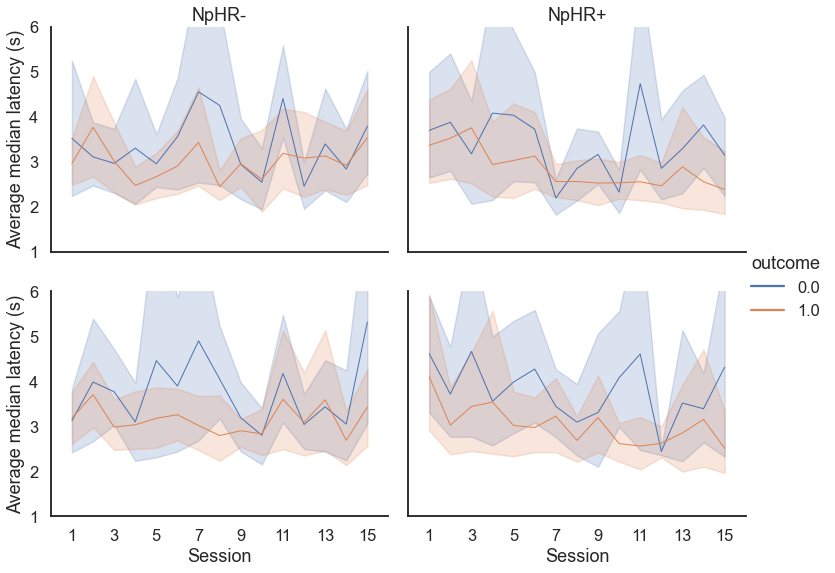

In [160]:

plt.figure(dpi=300)
sns.set(style='white', context='talk')
g = sns.relplot(kind='line', data=medians, col='group', row='stim_condition',
                x='session_nr', y='latency_to_cp_entry', hue='outcome',
                height=4, aspect=1.3, linewidth=1)

#for group, ax in g.axes_dict.items():
#    if 0 in group:
#        color='black'
#    else:
#        color='orangered'
        
#    data = medians[(medians['group']==group[1]) & (medians['stim_condition']==group[0])]
#    sns.lineplot(data=data, x='session_nr', y='latency_to_cp_entry',
#                 ci=None, color=color, linewidth=3, ax=ax, legend=False)
    
g.set(ylabel= 'Average median latency (s)', xlabel='Session', xlim=[0,16], ylim=[1,6],
      xticks=range(1,16,2), xticklabels=range(1,16,2))
#g._legend.remove()
axes = g.axes.flatten()
axes[0].set(title="NpHR-")
axes[1].set(title="NpHR+")
axes[2].set(title="")
axes[3].set(title="")
sns.despine()